# Data collection, and exploratory analysis

In [3]:
from sqlalchemy import create_engine
import pandas as pd
from holidays_co import is_holiday_date
import matplotlib.pyplot as plt

In [8]:
# Replace values with server ip, port and database credentials

host = 'xxx.xxx.xxx.xxx'
port = 'xxxx'
user = 'xxxx'
password = 'xxxx'
database= 'xxxx'



db_connection_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'.format(user=user, 
                                                                                           password=password,
                                                                                           host=host, 
                                                                                           port=port, 
                                                                                           database=database)

### Create SqlAlchemy engine

In [9]:
try:
    engine = create_engine(db_connection_string)
    print('Connection success')    
except Error as e:
    print("Connection fail", e)    

Connection success


### Get dataset from database

In [10]:
# Query to db tables
df = pd.read_sql_table(table_name='dvm_incidente', 
                       con=engine, 
                       columns=['fecha', 
                                'hora_reporte', 
                                'via',
                                'abscisa',
                                'tipo_atencion',
                                'condiciones_climaticas'
                               ]
                      )  

df_types = pd.read_sql_table(table_name='dvm_tipo_atencion', 
                             con=engine,
                             columns=['nombre'],
                             index_col='id'
                            ) 


df_vias = pd.read_sql_table(table_name='dvm_via', 
                             con=engine,
                             index_col='id'
                            ) 

/home/practicante/.local/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/reflection.py:193: SAWarning: Did not recognize type 'point' of column 'coordenadas'
  "Did not recognize type '%s' of column '%s'" % (type_, name)


In [11]:
df.head(3)

fecha hora_reporte  via  abscisa  tipo_atencion condiciones_climaticas
0 2011-06-22        14:00  5.0      NaN            3.0                   None
1 2011-06-23        14:00  4.0      0.0            6.0                   None
2 2011-06-25        02:00  4.0   4300.0            6.0                   None

In [12]:
print('\n'.join(df_types.nombre.to_list()))

Atropellamiento
Caída Motociclista
Colisión
Encunetado
Enfermedad Común
Inmovilizado
Varado
Volcamiento
Derrumbe
Servicio Comunitario
Servicio Fallido
Servicio Cancelado
Caída de árbol
Manifestación
Caída de piedras
Obstáculo en la vía
Salida de Vehiculo
Colisión con semoviente
Colisión solo latas
Riña
Homicidio
Asesinato
Vehículo Incinerado
Caída Ciclista 
Caída Ocupante
Colisión con objeto fijo 
Registro Duplicado
Aceite en la via 
Semoviente en la via 
Caída de peatón 
Evento Deportivo
Movilidad Normal
Fuga de gas
Izada de puente
Fallas de energia
Derrame de sustancias en la vía
Voladura de piedra
Conato de Incendio
Caída de Vehículo
Reclamo Usuario por Daño a Vehículo
Caída de piedras ocasiona daño
Caída de árbol ocasiona daño
Usuarios Concilian
Usuario con problemas de salud
Caída de carga
Derrumbe ocasiona daño a terceros
Vehículo sufre daño por falla en la vía
Cierre de vía
Reporte Valla o Publicidad 
Reporte Venta Ambulante o Estacionaria
Reporte Ocupación Irregular
Animal Muer

In [13]:
incident_types=['Atropellamiento', 
                'Caída Motociclista',
                'Colisión', 
                'Encunetado',
                'Volcamiento',
                'Salida de Vehiculo',
                'Colisión con semoviente',
                'Colisión solo latas',
                'Caída Ciclista ',
                'Caída Ocupante',
                'Colisión con objeto fijo ',
                'Semoviente en la via ',
                'Caída de peatón ',
                'Caída de Vehículo',
                'Incidente'
               ]
incident_types_indexes = df_types[df_types.nombre.isin(incident_types)].index.to_list()

### Filter dataframe by "tipo_atencion"

In [14]:
df = df.loc[(df.tipo_atencion.isin(incident_types_indexes))]

### Replace null values of "condiciones_climaticas" by "Normales"

In [15]:
df.condiciones_climaticas.fillna('NORMALES', inplace=True)
df.condiciones_climaticas.replace('', 'NORMALES',inplace=True)
df.head(3)

fecha hora_reporte  via  abscisa  tipo_atencion condiciones_climaticas
0 2011-06-22        14:00  5.0      NaN            3.0               NORMALES
6 2011-07-19        14:00  3.0  12800.0            3.0               NORMALES
7 2011-07-25        20:00  3.0  12800.0            3.0               NORMALES

### Drop "NaN" rows

In [16]:
df.dropna(inplace=True)
df.head(3)

fecha hora_reporte  via  abscisa  tipo_atencion condiciones_climaticas
6 2011-07-19        14:00  3.0  12800.0            3.0               NORMALES
7 2011-07-25        20:00  3.0  12800.0            3.0               NORMALES
8 2011-06-22        14:00  5.0   2800.0            3.0               NORMALES

### Drop "Santuario - Caño Algere" records

In [17]:
df.via.astype('int32')
df = df[df.via != 2]
df.count()

fecha                     14243
hora_reporte              14243
via                       14243
abscisa                   14243
tipo_atencion             14243
condiciones_climaticas    14243
dtype: int64

### Get day of the week.
> 0 -> Monday  
> 1 -> Tuesday  
> ...

In [18]:
df['dia_semana'] = df.fecha.dt.weekday
df['num_mes'] = df.fecha.dt.month
df['condiciones_climaticas'] = pd.Categorical(df.condiciones_climaticas).codes
df.head(3)

fecha hora_reporte  via  abscisa  tipo_atencion  \
6 2011-07-19        14:00  3.0  12800.0            3.0   
7 2011-07-25        20:00  3.0  12800.0            3.0   
8 2011-06-22        14:00  5.0   2800.0            3.0   

   condiciones_climaticas  dia_semana  num_mes  
6                       2           1        7  
7                       2           0        7  
8                       2           2        6

### Add holidays descriptor

In [19]:
df['dia_festivo'] = df.fecha.apply(is_holiday_date).astype('int')
df.head()

fecha hora_reporte  via  abscisa  tipo_atencion  \
6  2011-07-19        14:00  3.0  12800.0            3.0   
7  2011-07-25        20:00  3.0  12800.0            3.0   
8  2011-06-22        14:00  5.0   2800.0            3.0   
9  2011-10-12        02:00  5.0   2800.0            1.0   
11 2011-10-12        02:00  1.0  19700.0            3.0   

    condiciones_climaticas  dia_semana  num_mes  dia_festivo  
6                        2           1        7            0  
7                        2           0        7            0  
8                        2           2        6            0  
9                        2           2       10            0  
11                       2           2       10            0

### Basic plots

In [20]:
plt.figure(figsize=(8,5))
df.condiciones_climaticas.value_counts().plot.bar(color='indigo');
plt.title('Histogram  - climatic conditions');
plt.xticks([0, 1, 2, 3], [ 'Normal', 'Rain', 'Wind', 'Hailstorm']);

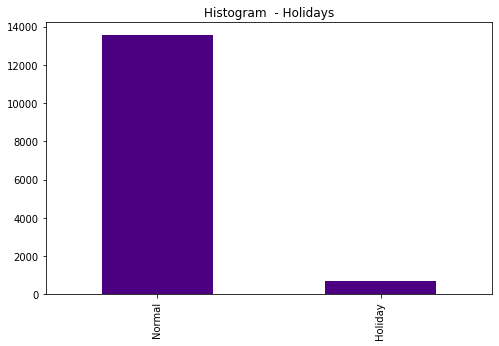

In [21]:
plt.figure(figsize=(8,5))
df.dia_festivo.value_counts().plot.bar(color='indigo');
plt.title('Histogram  - Holidays');
plt.xticks([0, 1], [ 'Normal', 'Holiday', ]);

In [22]:
plt.figure(figsize=(8,5))
df.dia_semana.value_counts().sort_index().plot.bar(color='indigo');
plt.title('Histogram  - day of week');
plt.xticks([0, 1, 2, 3, 4, 5, 6], [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sunm']);

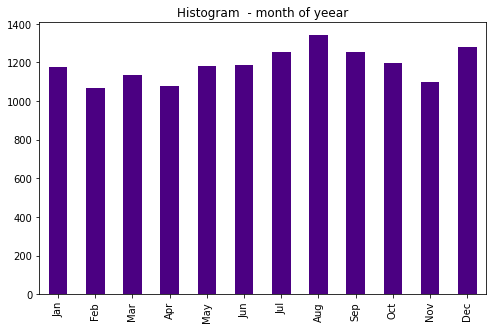

In [23]:
plt.figure(figsize=(8,5))
df.num_mes.value_counts().sort_index().plot.bar(color='indigo');
plt.title('Histogram  - month of yeear');
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
           [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

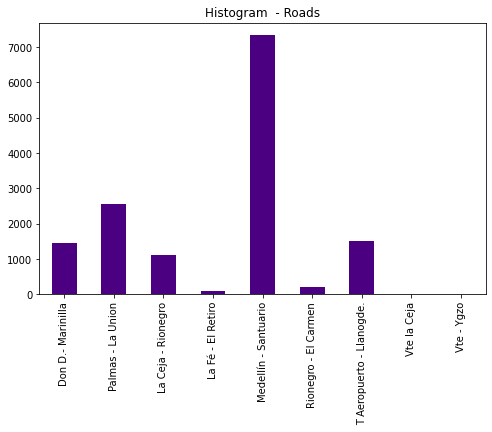

In [24]:
plt.figure(figsize=(8,5))
df.via.value_counts().sort_index().plot.bar(color='indigo');                                  
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['Don D.- Marinilla', 
                                             'Palmas - La Union', 
                                             'La Ceja - Rionegro', 
                                             'La Fé - El Retiro',
                                             'Medellín - Santuario',
                                             'Rionegro - El Carmen',
                                             'T Aeropuerto - Llanogde.', 
                                             'Vte la Ceja', 
                                             'Vte - Ygzo']);
plt.title('Histogram  - Roads');

### Export dataframes as csv to add geographic coordinates and clusters 

In [25]:
df.to_csv('./Csv/accidentes.csv')
df_vias.to_csv('./Csv/vias.csv')